In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="qN4kXsL6ciaQC2x0nvIA")
project = rf.workspace("ab-alab-x5qjn").project("chest_xray-xfuk8")
dataset = project.version(1).download("folder")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 862.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninst

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to chest_xray-1 in folder:: 100%|██████████| 5832/5832 [00:02<00:00, 2290.58it/s]


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import GroupNormalization
import cv2
import random
import tensorflow as tf
import matplotlib.pyplot as plt

src_path_train = "/content/chest_xray-1/train"
src_path_test = "/content/chest_xray-1/valid"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        )

test_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",)
batch_size = 8
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=8,
    class_mode="categorical",
    shuffle=False,
    seed=42
)
import tqdm
import numpy as np
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm.tqdm(range(int(train_generator.n/batch_size)-1)):
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)
import tqdm
import numpy as np
test_generator.reset()
X_test, y_test = next(test_generator)
for i in tqdm.tqdm(range(int(test_generator.n/batch_size)-1)):
    img, label = next(test_generator)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)


Found 5190 images belonging to 2 classes.
Found 634 images belonging to 2 classes.


100%|██████████| 647/647 [01:41<00:00,  6.37it/s]


(5184, 100, 100, 3) (5184, 2)


100%|██████████| 78/78 [00:03<00:00, 22.38it/s]

(632, 100, 100, 3) (632, 2)


In [3]:
from keras.applications import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

# Load MobileNet model with pre-trained weights (include_top=False to exclude the fully connected layers)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Add a GlobalAveragePooling2D layer to reduce spatial dimensions
x = GlobalAveragePooling2D()(base_model.output)

# Create a new model with MobileNet as the base and the added pooling layer
feature_extractor_model = Model(inputs=base_model.input, outputs=x)

# Extract features from the training and testing datasets
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)
# Flatten the features to use them with LightGBM
X_train_features_flatten = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_flatten = X_test_features.reshape(X_test_features.shape[0], -1)






20/20 [==============================] - 1s 16ms/step


In [4]:
from keras.applications import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
import lightgbm as lgb
import joblib
model_params = {
    'objective': 'binary ',
}

    #'objective': 'multiclass',
   # 'num_class':3,

# Define and train the LightGBM model
lgb_model = lgb.LGBMClassifier(**model_params)
lgb_model.fit(X_train_features_flatten, np.argmax(y_train, axis=1))

# Make predictions on the test set
y_pred = lgb_model.predict(X_test_features_flatten)

# Evaluate the accuracy
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("Accuracy:", accuracy)


[LightGBM] [Info] Number of positive: 3846, number of negative: 1338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234090
[LightGBM] [Info] Number of data points in the train set: 5184, number of used features: 1017
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.741898 -> initscore=1.055858
[LightGBM] [Info] Start training from score 1.055858
Accuracy: 0.8022151898734177


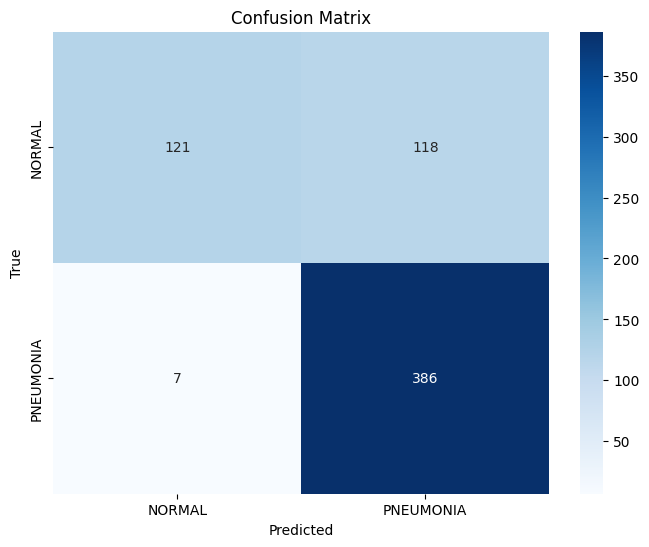

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = lgb_model.predict(X_test_features_flatten)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

class_labels = ["NORMAL", "PNEUMONIA"]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [6]:
import joblib

lgb_model_file = '/content/model.joblib'
joblib.dump(lgb_model, lgb_model_file)

['/content/model.joblib']